# Import packages and helper functions

In [1]:
import pandas as pd
import collections
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import numpy as np
from collections import deque
import warnings
import pickle
from itertools import combinations
import gower
import time
import statistics

warnings.filterwarnings("always", category=UserWarning)
# Set NumPy print options
np.set_printoptions(precision=2, suppress=True)

# Set Pandas options
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [31]:
def remove_none_values(dictionary: dict) -> dict:
    """
    Removes none values from the layers in the cluster dictionary

    Parameters:
    dictionary: Cluster dictionary 
    """
    new_dict = {}
    for key, value in dictionary.items():
        d = {index: element for index, element in enumerate(value) if element != [None]}
        new_dict[key] = d

    return new_dict

def clus_layer_dict(clusters: dict, end_layer: int) -> dict:
    """
    Creates a dictionary of all the cluster layers, as sometimes the cluster
    dictionary contains redundant extra layers.

    Parameters:
    clusters: Cluster dictionary 
    end_layer: last layer of cluster, given by the cluster algorithm
    """    
    filtered_dict = {k: v for k, v in clusters.items() if k <= end_layer}
    return filtered_dict

def clus_per_top(data: list, classes: pd.Series) -> tuple:
    """
    Finds the most common class in a cluster, and returns the class and its percentage.

    Parameters:
    data: A list of indexes representing data points in the cluster.
    classes: A series of the names of the classes, required to calculate the most common class.
    """    
    counters = []
    l = []
    for j in data:
        l.append(classes[j])
    counter = collections.Counter(l)
    counters.append(counter)
    sort = counter.most_common(1)[0][0]
    perc = counter.most_common(1)[0][1]/len(l) * 100
    if all(value == counter.most_common()[0][1] for _, value in counter.most_common()):
        tops = ('All', 0)
    else:
        tops = (sort, perc)
    return tops

# VHK algorithm (Mieke)

In [ ]:
def gower_distance(matrix):
    output = gower.gower_matrix(matrix)
    return output

#This function computes the standard deviation of numerical features

def numerical_std(numerical_variable):
    name = numerical_variable.name
    Vmin = numerical_variable.min()
    Vmax = numerical_variable.max()
    Vnorm = (numerical_variable-Vmin)/(Vmax-Vmin)
    norm_std = statistics.stdev(Vnorm.tolist())
    return norm_std


def categorical_variation(categorical_variable):
    name = categorical_variable.name
    q = categorical_variable.nunique()
    n = categorical_variable.count() 
    values_list = categorical_variable.drop_duplicates().to_list()
    if (q==1):
        return 0 
    else:
        frequencies = []
        for val in values_list:
            f = categorical_variable.value_counts()[val] / n
            frequencies.append(f)
        f2 = 0
        for i in np.arange(q):
            f2 += (frequencies[i]**2)
        v = 1 - np.sqrt(f2)
        v_s = v / (1-1/(np.sqrt(q)))
        return v_s
    
    #This function computes the variability of a cluster

def variability(matrix,clusters,cluster_number, cat_features, num_features):
    c_indices = clusters[cluster_number]
    if c_indices == [None]:
        return [None]
    matrix_subset = matrix.loc[c_indices,:]
    dict_var = {}
    for column in matrix.columns:
        if (column in cat_features):
            dict_var[column] = categorical_variation(matrix_subset[column])
            #print(column , '\t', "%.2f" % categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            #print(column , '\t', "%.2f" % (numerical_std(matrix_subset[column])/np.sqrt(1/12)), '\t', numerical_std(matrix_subset[column]))
            dict_var[column] = min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1)
    return dict_var


def mieke(X, cat_features, num_features, all_features):
    # -------------------------------------------------------------------------------------
    # Define the cluster target (X), the number of clusters (k), max number of layers (l>>) 
    # and thershold size for cluster cardinality (n)
    # -------------------------------------------------------------------------------------

    k = 2 #number of clusters each clustering step
    l = 50 #max number of layers
    n = len(X) #size of dataset


    # -------------------------------------------------------------------------------------
    # Semi-hierarchical clustering algorithm 
    # -------------------------------------------------------------------------------------

    t0 = time.time() # report running time 

    dict_layers = {0:[X.index.tolist()]} 
    dict_medoids = {0:[]}
    dict_stable = {0: {0:[]}}
    dict_irrelevant = {0: {0:[]}}
    dict_uniform = {0: {0:[]}}
    for i in np.arange(1,l):
        dict_layers[i] = []
        dict_medoids[i] = []
        dict_stable[i] = {}
        dict_irrelevant[i] = {}
        dict_uniform[i] = {}

    for layer in np.arange(l-1): #iterate over layers
        final_layer = True

        for i in np.arange(k**layer): 
            dict_stable[layer+1][i] = []
            dict_irrelevant[layer+1][i] = []
            dict_uniform[layer+1][i] = []
            subset_index = dict_layers[layer][i] 
            
            if (subset_index == [None]):
                for j in np.arange(k):
                    dict_layers[layer+1].append([None])
                    dict_medoids[layer+1].append([None])

            
            elif (len(subset_index) < 0.05*n): 
                dict_layers[layer+1].append(dict_layers[layer][i])
                dict_medoids[layer+1].append(dict_medoids[layer][i])
                dict_layers[layer+1].append([None])
                dict_medoids[layer+1].append([None])

            else:
                X_subset = X.loc[subset_index,:]
                var_subset = variability(X,dict_layers[layer],i, cat_features, num_features) 
                test_variability = False 
                
                for feature in all_features:
                    if((var_subset[feature]>0.2) and (var_subset[feature]<0.8) ):
                        test_variability = True
                        dict_irrelevant[layer+1][i].append(feature) #IK
                    if var_subset[feature]<0.2 : #IK
                        dict_stable[layer+1][i].append(feature)
                    if var_subset[feature]>0.8: #IK
                        dict_uniform[layer+1][i].append(feature)

                if (test_variability == False):
                    dict_layers[layer+1].append(dict_layers[layer][i])
                    dict_medoids[layer+1].append(dict_medoids[layer][i])
                    dict_layers[layer+1].append([None])
                    dict_medoids[layer+1].append([None])
                    
                else:
                    index_book = {} #keep track of indices of cluster i
                    teller = 0 
                    for index in X_subset.index:
                        index_book[teller] = index
                        teller += 1

                    X_subset = X_subset.reset_index(drop=True) #reset index of cluster i before cluster analysis

                    initial_medoids = np.sort(random.sample(list(X_subset.index),k))
                    kmedoids_instance = kmedoids(gower_distance(X_subset),initial_medoids,data_type='distance_matrix',iter_max=1000)
                    kmedoids_instance.process()
                    clusters = kmedoids_instance.get_clusters()
                    centers = kmedoids_instance.get_medoids()
                    final_layer = False

                    for j in np.arange(k): #translate cluster index back to original
                        translated_cluster = []
                        for item in clusters[j]:
                            translated_cluster.append(index_book[item])
                        dict_medoids[layer+1].append(index_book[centers[j]])
                        dict_layers[layer+1].append(translated_cluster)

        if (final_layer == True):
            end_layer = layer
            break

    final_clusters_full = dict_layers[end_layer]
    final_medoids_full = dict_medoids[end_layer]

    final_clusters = []
    final_medoids = []
    for cluster in final_clusters_full:
        if (cluster != [None]):
            final_clusters.append(cluster)
    for medoid in final_medoids_full:
        if (medoid != [None]):
            final_medoids.append(medoid)    

    #sort the clusters, in this way we always obtain the same cluster numbers 
    sort_clusters = final_clusters.copy()
    sort_clusters.sort(key=len)
    sort_centers = []
    for i in np.arange(len(final_clusters)):
        for j in np.arange(len(final_clusters)):
            if (sort_clusters[i] == final_clusters[j]):
                sort_centers.append(final_medoids[j])


    print("training time:", round(time.time()-t0, 3), "s")
    print("Final number of clusters:", len(sort_clusters))
    
    return sort_clusters, sort_centers, dict_layers, end_layer

# Read Datasets

In [3]:
df_fruit = pd.read_csv("fruitsModified2.csv")

# Clean dataset and translate
df_fruit = df_fruit[10:]
df_fruit = df_fruit.reset_index().drop(['index'], axis=1)
df_fruit.loc[df_fruit['fruit'].str.startswith('abricot'), 'fruit'] = 'apricot'
df_fruit.loc[df_fruit['fruit'].str.startswith('pomme'), 'fruit'] = 'apple'
df_fruit.loc[df_fruit['fruit'].str.startswith('carotte'), 'fruit'] = 'carrot'
df_fruit.loc[df_fruit['fruit'].str.startswith('cerise'), 'fruit'] = 'cherry'
df_fruit.loc[df_fruit['fruit'].str.startswith('banane'), 'fruit'] = 'banana'
df_fruit.loc[df_fruit['fruit'].str.startswith('tomate'), 'fruit'] = 'tomato'
df_fruit.loc[df_fruit['fruit'].str.startswith('poire'), 'fruit'] = 'pear'
df_fruit.loc[df_fruit['fruit'].str.startswith('patate'), 'fruit'] = 'potato'
df_fruit.loc[df_fruit['fruit'].str.startswith('prune'), 'fruit'] = 'plum'
df_fruit.loc[df_fruit['fruit'].str.startswith('poivron'), 'fruit'] = 'bell pepper'

# Save fruit types as series
type_fruit = df_fruit['fruit']

# Make dict of descriptions per fruit
descrips_fruit = {}
for i in ['apricot', 'apple', 'carot', 'cherry', 'banana', 'tomato', 'pear', 'potato', 'plum', 'bell pepper']:
    df_fd = df_fruit[df_fruit['fruit'] == i].describe(include='all')
    descrips_fruit[i]= df_fd.drop(['fruit', 'v_longueur','v_largeur','v_teinte','v_sucre','v_eau','v_fibre' ], axis=1)

# Drop irrelevant columns    
df_fruit.drop(['fruit', 'v_longueur','v_largeur','v_teinte','v_sucre','v_eau','v_fibre' ], axis=1, inplace=True)
df_fruit.columns = ['length', 'width', 'tint', 'sugar', 'water', 'fiber']
df_fruit.head()

scaled_data = scaler.fit_transform(df_fruit)

df_fruit_s = pd.DataFrame(scaled_data, columns=df_fruit.columns)

# Read clusters generated VHK


In [39]:
file_path = "dict_f.pkl"

# Load the dictionary of prior generated clustering from the file
with open(file_path, "rb") as file:
    cl_fruit = pickle.load(file)

# cl_fruit is a tuple of length 4: sort_clusters, sort_centers, dict_layers, end_layer

4


# Tree class

In [5]:
"""
Node Class:
- Description: Represents a node in a hierarchical tree structure.

Attributes:
- label: A tuple representing the node's position in the hierarchy (layer, cluster number).
- df: The dataset (DataFrame) from which data is extracted, with the option to choose scaled or unscaled data.
- data: A list of indexes representing data points in the cluster.
- classes: A series of the names of the classes, required to calculate the most common class.

Data Stored in a Node:
- label: The node's label.
- data: The data points stored in the node.
- df: The dataset extracted with the specified indices.
- mean: The mean of the cluster (unscaled).
- stdev: The standard deviation of the cluster (unscaled).
- means: The mean of the cluster (scaled).
- stdevs: The standard deviation of the cluster (scaled).
- common: The most common class in the cluster and its percentage.
- children: A list to keep track of child nodes.
- meandif: The difference between means (scaled) of the node and its parent.
- stdevdif: The difference between standard deviations (scaled) of the node and its parent.

Important Note on Differences (meandif and stdevdif):
- The parent node is min-max scaled, and the differences are calculated based on this scaling. 
    It's not the differences between the means or stdevs stored in these attributes.

Class Methods:
- add_child(child): Adds a child node to the current node.
- remove_child(child): Removes a child node from the current node.
"""
class Node:
    def __init__(self, label: tuple, df: pd.DataFrame, data: list, classes: pd.Series):
        """
        Initializes a Node instance.

        Parameters:
        - label: A tuple representing the node's position in the hierarchy (layer, cluster number).
        - df: The dataset (DataFrame) from which data is extracted, with the option to choose scaled or unscaled data.
        - data: A list of indexes representing data points in the cluster.
        - classes: A series of the names of the classes, required to calculate the most common class.
        """
        self.label = label  
        self.data = data    
        self.df = df.loc[data, :]
        s=scaler.fit_transform(df)
        self.dfs = pd.DataFrame(data=s, columns=df.columns).loc[data, :]              
        self.mean = np.array(np.mean(df.loc[data, :], axis=0)) if data is not None else None    
        self.stdev = np.array(np.std(df.loc[data, :], axis=0)) if data is not None else None    
        self.means = np.array(np.mean(self.dfs, axis=0)) if data is not None else None    
        self.stdevs = np.array(np.std(self.dfs, axis=0)/np.sqrt(1/12)) if data is not None else None    
        self.common = (clus_per_top(data, classes)[0], np.round(clus_per_top(data, classes)[1]))
        self.children = [] 
        self.meandif = None
        self.stdevdif = None

    def add_child(self, child):
        """
        Adds a child node to the current node's list of children.

        Parameters:
        - child: The child Node instance to be added.
        """
        self.children.append(child)

    def remove_child(self, child):
        """
        Removes a child node from the current node's list of children.

        Parameters:
        - child: The child Node instance to be removed.
        """
        self.children.remove(child)


"""
Tree Class:
- Description: Represents a hierarchical tree structure composed of nodes.

Attributes:
- root: The root node of the tree.
- node_mapping: A mapping to store nodes based on their labels.
- region: Object regions, which are the topmost nodes that contain more than 80% of a single class.
- rmdif: Mean difference with object region nodes and the root node.
- rsdif: Standard deviation difference with object region nodes and the root node.
- rrandif: Range difference (as a ratio) with object region nodes and the root node.
- rmdifs: Mean difference with object region nodes and the root node (scaled).
- rsdifs: Standard deviation difference with object region nodes and the root node (scaled).

Class Methods:
- add_node(node): Adds a node to the tree, connecting it to its parent.
- get_node(label): Retrieves a node from the mapping based on its label.
- remove_child(child_node): Removes a child node from the tree.
- remove_self_and_children(node): Removes the current node and all its children.
- print_tree(how, node, indent, last_child): Prints the tree structure with different display options ('l', 'c', 'd', 'm', 's', 'mdif', 'sdif').
- remove_same_data_children(node): Removes child nodes with the same 'data' as the parent.
- generate_regions(): Generates object regions and calculates differences.
"""
class Tree:
    def __init__(self):
        self.root = None
        self.node_mapping = {}  
        self.region = []    
        self.rmdif = []     
        self.rsdif = []     
        self.rrandif = []   
        self.rmdifs = []     
        self.rsdifs = []     

    def add_node(self, node: Node):   
        """
        Adds a node to the tree, connecting it to its parent.

        Parameters:
        - node: The Node instance to be added to the tree, initiated with the Node class.
        """
        scaler = MinMaxScaler()
        if self.root is None:   
            self.root = node
            self.node_mapping[node.label] = node
        else:
            parent_label = (node.label[0] - 1, node.label[1] // 2)      
            parent = self.node_mapping.get(parent_label)
            if parent is not None:
                parent.add_child(node)
                self.node_mapping[node.label] = node

                # Min-Max scale the parent and calculate differences
                indices = parent.df.index
                scaled_data = scaler.fit_transform(parent.df)
                # Create a new DataFrame with the scaled data
                scaled_df = pd.DataFrame(scaled_data, columns=parent.df.columns)
                # Reassign the original indices to the scaled DataFrame
                scaled_df.index = indices
                node.meandif = np.array(np.mean(scaled_df.loc[node.data, :], axis=0)) - np.array(np.mean(scaled_df, axis=0))  #add differences
                node.stdevdif = np.array(np.std(scaled_df.loc[node.data, :], axis=0)/np.sqrt(1/12)) - np.array(np.std(scaled_df, axis=0)/np.sqrt(1/12))
            else:
                raise ValueError("Parent node not found for label:", parent_label)

    def get_node(self, label: tuple):  
        """
        Retrieve the node corresponding to the label from the mapping.

        Parameters:
        - label: The label of the Node to be retrieved.
        """
        return self.node_mapping.get(label)

    def remove_child(self, child_node: Node):     #used to remove self and children
        """
        Removes a child node from the tree.

        Parameters:
        - child_node: The child Node instance to be removed.
        """
        child_node.parent.children.remove(child_node)

    def remove_self_and_children(self, node: Node):
        """
        Removes a node and its children from the tree.

        Parameters:
        - node: The Node instance to be removed.
        """
        if node.parent is not None:     # if the parent is not the root, remove the child
            node.parent.remove_child(node)
        for child in node.children:     
            self.remove_self_and_children(child)

    # six options for what to display in the tree
    def print_tree(self, how: str, node: Node = None , indent="", last_child=True):
        """
        Prints the tree structure with different display options ('l', 'c', 'd', 'm', 's', 'mdif', 'sdif').

        Parameters:
        - how: What the printed tree should display, with the following options: l, c, d, m, s, mdif, sdif
                l: only labels
                c: labels and most common class at the node
                d: labels and data
                m: labels and mean
                s: labels and standard deviation
                mdif: labels and mean difference
                sdif: labels and standard deviation difference
        - node: The starting node of the subset of the enitire tree you want to display.
        - indent: Helps with printing the tree.
        - last_child: Recursively finds the last child, and stops when it is reached.
        """
        
        if node is None:
            node = self.root
        if isinstance(node, tuple):                 
            node = self.node_mapping.get(node)      

        marker = "└── " if last_child else "├── "
        if how == 'l':      
            print(indent + marker + str(node.label))
        elif how == 'c':    
            print(indent + marker + str(node.label) +': ' + str(node.common))
        elif how == 'd':    
            print(indent + marker + str(node.label) +': ' + str(node.data))
        elif how == 'm':    
            print(indent + marker + str(node.label) +': ' + str(node.mean))
        elif how == 's':    
            print(indent + marker + str(node.label) +': ' + str(node.stdev))
        elif how == 'mdif':    
            newlist = None
            if type(node.meandif) == np.ndarray:
                sorted_list = sorted(enumerate(node.meandif), key=lambda x: (abs(x[1]), x[1]!=0))
                columns = node.df.columns 
                newlist = []
                for i, v in sorted_list:
                    newlist.append((round(v, 2), columns[i]))
            print(indent + marker + str(node.label) +': ' + str(newlist))

        elif how == 'sdif':    
            newlist = None
            if type(node.stdevdif) == np.ndarray:
                sorted_list = sorted(enumerate(node.stdevdif), key=lambda x: (abs(x[1]), x[1]!=0))
                columns = node.df.columns 
                newlist = []
                for i, v in sorted_list:
                    newlist.append((round(v, 2), columns[i]))
            print(indent + marker + str(node.label) +': ' + str(newlist))
        

        for i, child in enumerate(node.children):
            is_last = (i == len(node.children) - 1)
            child_indent = indent + ("    " if last_child else "│   ")
            self.print_tree(how, child, child_indent, is_last)

    def remove_same_data_children(self, node=None):
        """
        Traverses through the children recursively and checks if any child has the same data
        as its parent and removes it. It removes duplicate nodes.

        Parameters:
        - node: The starting node, and the current node (used in recursive calls).
        """
        if node is None:
            node = self.root

        for child in node.children:
            self.remove_same_data_children(child)

        for child in node.children:
            if child.data == node.data:
                node.remove_child(child)

    def generate_regions(self):
        """
        Generates object regions, which are the topmost nodes that contain more than 80% of a single class.
        Calculates differences.
        """
        queue = deque([self.root])

        while queue:
            node = queue.popleft()

            # If more than once in the same layer, remove the one with less elements
            matching = [item for item in self.region if item[0][0] == node.label[0] and item[1][0] == node.common[0]]
            if node.common[1] >= 80 and matching:
                warnings.warn("The " + node.common[0] + " region present more than once in layer: " + str(node.label[0]), UserWarning)
                for item in matching:
                    if len(self.node_mapping.get(item[0]).data) < len(node.data):
                        self.region.remove(item)

            if node.common[1] >= 80 and node.common[0] not in [item[1][0] for item in self.region]: 
                self.region.append((node.label, node.common))
                self.rmdif.append(((node.common[0]), node.mean - self.root.mean))
                self.rsdif.append(((node.common[0]), node.stdev - self.root.stdev))
                self.rmdifs.append(((node.common[0]), node.means - self.root.means))
                self.rsdifs.append(((node.common[0]), node.stdevs - self.root.stdevs))
                rangeper = np.round(((node.df.max() - node.df.min()) / (self.root.df.max() - self.root.df.min())).values, 2)
                self.rrandif.append(((node.common[0]), rangeper.tolist()))

            queue.extend(node.children)

In [6]:

def create_tree2(c_l_dict: dict, df: pd.DataFrame, classes: pd.Series) -> Tree:
    """
    Creates a hierarchical tree structure based on the provided cluster data.

    Parameters:
    - c_l_dict: A dictionary with the structure {layer: {cluster: [items]}} representing clusters in different layers.
    - df: The dataset, either scaled or not.
    - classes: Series of all the classes
    Returns:
    - tree: A Tree instance representing the hierarchical tree structure.
    """
    tree =  Tree()

    for key, value in c_l_dict.items():
        for k, v in value.items():
            node = Node((key, k), df, v, classes)
            tree.add_node(node)

    tree.remove_same_data_children()
    tree.generate_regions()
    return tree

In [7]:
# Step 1: Remove None Values and Create a Cluster Dictionary
# Description: Remove None values from the cluster data and create a hierarchical cluster dictionary.

# cl_fruit[2]: Clusters
# cl_fruit[3]: End layer
# d: The hierarchical cluster dictionary without None values.
d = remove_none_values(clus_layer_dict(cl_fruit[2], cl_fruit[3]))

# Step 2: Create a Tree Based on the Cluster Dictionary
# Description: Create a hierarchical tree structure based on the cluster dictionary, using a specified dataset and its classes.

# d: The hierarchical cluster dictionary created in Step 1.
# df_fruit: The dataset.
# type_fruit: Series of the names of the classes.

# tree: The hierarchical tree structure representing the clusters and their relationships.
tree = create_tree2(d, df_fruit, type_fruit)

# Step 3: Print the Tree Structure with Common Classes
# Description: Print the hierarchical tree structure with labels and common classes.

# how='c': Display labels and common classes for each node in the tree.
tree.print_tree(how='c')


└── (0, 0): ('All', 0)
    ├── (1, 0): ('carrot', 17.0)
    │   ├── (2, 0): ('bell pepper', 21.0)
    │   │   ├── (3, 0): ('tomato', 96.0)
    │   │   │   ├── (4, 0): ('tomato', 98.0)
    │   │   │   │   ├── (5, 0): ('tomato', 97.0)
    │   │   │   │   └── (5, 1): ('tomato', 98.0)
    │   │   │   │       ├── (6, 2): ('All', 0)
    │   │   │   │       └── (6, 3): ('tomato', 98.0)
    │   │   │   │           ├── (7, 6): ('tomato', 99.0)
    │   │   │   │           └── (7, 7): ('tomato', 94.0)
    │   │   │   └── (4, 1): ('tomato', 87.0)
    │   │   └── (3, 1): ('bell pepper', 27.0)
    │   │       ├── (4, 2): ('apricot', 49.0)
    │   │       │   ├── (5, 4): ('apricot', 86.0)
    │   │       │   │   ├── (6, 8): ('apricot', 46.0)
    │   │       │   │   └── (6, 9): ('apricot', 90.0)
    │   │       │   │       ├── (7, 18): ('apricot', 89.0)
    │   │       │   │       └── (7, 19): ('apricot', 90.0)
    │   │       │   │           ├── (8, 38): ('apricot', 93.0)
    │   │       │   │       

<ipython-input-5-aa49ad13e4f1>:258: UserWarning: The pear region present more than once in layer: 3
  warnings.warn("The " + node.common[0] + " region present more than once in layer: " + str(node.label[0]), UserWarning)


In [28]:
def display_tree_regions(tree: Tree):
    """
    Display information about tree regions in a readable manner.

    Parameters:
    tree: Prior initialized tree of clustering
    """
    for i in range(len(tree.region)):
        print('-----------------\n')
        print(tree.region[i],':')
        print('-----------------')
        print('Absolute mean difference:\t', tree.rmdif[i][1])
        print('Absolute stdev difference:\t', tree.rsdif[i][1])
        print('-----------------')
        print('Scaled mean difference:\t\t', tree.rmdifs[i][1])
        print('Scaled stdev difference:\t', tree.rsdifs[i][1])
        print('-----------------')
        print('Percentage of range left:\t', tree.rrandif[i][1])
        print('-----------------')
        tree.print_tree(node=tree.region[i][0], how='mdif')
        print('\n-----------------')

In [29]:
display_tree_regions(tree)

-----------------

((2, 2), ('banana', 93.0)) :
-----------------
Absolute mean difference:	 [10.06 -3.64 -1.86  7.05 -9.32  0.07]
Absolute stdev difference:	 [ -1.8   -1.26 -30.59  -1.71  -2.95  -0.09]
-----------------
Scaled mean difference:		 [ 0.22 -0.08 -0.01  0.22 -0.2   0.01]
Scaled stdev difference:	 [-0.14 -0.1  -0.33 -0.19 -0.22 -0.04]
-----------------
Percentage of range left:	 [0.66, 0.67, 0.2, 0.79, 0.54, 0.63]
-----------------
└── (2, 2): [(0.01, 'fiber'), (-0.05, 'width'), (-0.14, 'tint'), (0.14, 'sugar'), (-0.17, 'water'), (0.27, 'length')]
    ├── (3, 4): [(-0.02, 'length'), (0.08, 'width'), (0.17, 'fiber'), (-0.21, 'sugar'), (0.22, 'water'), (0.38, 'tint')]
    └── (3, 5): [(0.0, 'length'), (-0.0, 'width'), (-0.01, 'fiber'), (0.01, 'sugar'), (-0.01, 'water'), (-0.02, 'tint')]
        ├── (4, 10): [(-0.0, 'tint'), (0.0, 'length'), (-0.01, 'water'), (0.02, 'sugar'), (0.02, 'fiber'), (-0.14, 'width')]
        └── (4, 11): [(0.0, 'tint'), (-0.0, 'length'), (0.0, 'water

# Co-occurences

In [12]:

def find_cocurrences(lists: list) -> dict:
    """
    Identify co-occurrences between features within a object region.

    This function takes a list of lists, where each inner list represents a the 'meandif' values for each feature.
    It calculates and returns the co-occurrence of values that are within a specified threshold (0.01).

    Parameters:
    - lists: A list of lists, where each inner list represents a the 'meandif' values for each feature.
        Initiated with get_list(label, node, list) function.

    Returns:
    - cocur: A dictionary containing co-occurrences of feature index combinations and their ratios.

    Example:
    ```
    co_occurences = find_cocurrences(get_list((2,2), list=[]))
    print(co_occurrences)
    ```
    Output:
    ```
    {(0, 1): 0.29, (0, 3): 0.43, (0, 5): 0.29, (1, 3): 0.43, (3, 5): 0.43, (0, 1, 3): 0.29, (0, 3, 5): 0.29, (2, 4): 0.29, (2, 5): 0.29, (4, 5): 0.57, (2, 4, 5): 0.29, (0, 2): 0.29}
    ```
    """
    result = []  # List to store sets per list
    for lst in lists:
        sets = []  # List to store sets of co-occuring elements within each list
        visited = set()  # Set to keep track of visited elements
        
        for i in range(len(lst)):
            if i not in visited:
                current_set = {i} # Start a new set with the current index
                visited.add(i)  # Mark the current index as visited
                
                for j in range(i + 1, len(lst)):
                    # If the difference is small enough select nodes
                    if abs(lst[i] - lst[j]) <= 0.01:       # Change to the desired value
                        current_set.add(j)  # Add index to the current set
                        visited.add(j)  # Mark the index as visited
                        
                if len(current_set) > 1:
                    sets.append(current_set)  # Add the set to the list of sets
        
        result.append(sets)  # Add the sets for the current list to the result list
    
    flat_list = [item for sublist in result for item in sublist]

    subset_counts = {}

    # Generate all possible subsets of length 2 or more
    subsets = []
    for s in flat_list:
        for r in range(2, len(s) + 1):
            subsets.extend(combinations(s, r=r))

    # Count the occurrences of each subset
    for subset in subsets:
        if subset in subset_counts:
            subset_counts[subset] += 1
        else:
            subset_counts[subset] = 1

    # Filter the subsets that occur in more than one set
    cocur = {subset: round(count/len(lists),2) for subset, count in subset_counts.items() if count > 1}

    return cocur




In [17]:

def get_list(label: tuple, node: Node = None, list: list = []) -> list:
    """
    Retrieves a list of 'meandif' values from nodes in the tree below the node with a given label.
    The tree needs to be created beforehand.

    Used for finding co-currences in a object region: find_cocurrences(lists).

    Parameters:
    - label: The label of the starting node from where on you want to retrieve 'meandif' values.
    - node: The starting node, and the current node (used in recursive calls).
    - lst: The list to store 'meandif' values (used in recursive calls).

    Returns:
    - list: A list of 'meandif' values per feature from nodes below the starting node.
    """
    if node == None:
        node = tree.node_mapping.get(label) 
    list.append(node.meandif)
    for i, child in enumerate(node.children):
        get_list(None, child, list)
    return list

In [23]:
def display_coocurrences(tree: Tree, df: pd.DataFrame, threshold: float = 0.6, R: float = -0.236):
    """
    Displays all co-occurrences per class and what percentage of these feature combinations co-occur.

    Parameters:
    tree: Prior initialized tree of clustering
    df: dataframe used for the clustering
    threshold: At what ratio the features combinations should co-occur to be considered co-occuring features
    R: Relevance bound: see thesis 4.1.3 description heuristics
    """
    for i in range(len(tree.region)):
        print('A ' + tree.region[i][1][0] + ' is a fruit with', end=' ')
        # reverse order of standard deviation 
        order = sorted(enumerate(tree.rsdifs[i][1]), key=lambda x: (abs(x[1]), x[1]!=0), reverse=True)

        for j in range(len(order)):
            if order[j][1] <= R: 
                fruit = df_fruit.columns.tolist()[order[j][0]]
                if tree.rmdifs[i][1][order[j][0]] < 0:
                    print('less ' + fruit,  end=', ')
                if tree.rmdifs[i][1][order[j][0]] > 0:
                    print('more ' + fruit,  end=', ')
        print('\n')
        print('Co-occcurrences in a '+tree.region[i][1][0]+':')
        sorted_data = dict(sorted(find_cocurrences(get_list(tree.region[i][0], list=[])).items(), key=lambda x: x[1], reverse=True))
        if next(iter(sorted_data.items()))[1] < threshold:
            print('None')
        for key, value in sorted_data.items():
            if value >= 0.6:        #change to the desired value
                print(value, end=': ')
                for k in key:
                    print(df_fruit.columns.tolist()[k], end=', ')
                print('')
        print('----------------------\n')

In [24]:
display_coocurrences(tree, df_fruit)

A banana is a fruit with less tint, 

Co-occcurrences in a banana:
None
----------------------

A tomato is a fruit with less sugar, more water, 

Co-occcurrences in a tomato:
0.78: tint, sugar, 
0.78: water, fiber, 
----------------------

A potato is a fruit with less sugar, less water, less tint, 

Co-occcurrences in a potato:
0.71: tint, fiber, 
0.71: sugar, fiber, 
----------------------

A pear is a fruit with more sugar, more tint, 

Co-occcurrences in a pear:
None
----------------------

A cherry is a fruit with more sugar, less water, 

Co-occcurrences in a cherry:
0.85: width, fiber, 
0.77: length, fiber, 
0.69: length, width, 
0.69: length, width, fiber, 
----------------------

A apricot is a fruit with less length, more tint, 

Co-occcurrences in a apricot:
0.62: tint, sugar, 
0.62: tint, fiber, 
----------------------

A apple is a fruit with less tint, more water, less length, less sugar, 

Co-occcurrences in a apple:
0.6: water, fiber, 
----------------------

A carrot 

# Bar Charts (extra example)

I left this here so you can see in more detail how the code can be used. But it is not any new or relevant code.

In [19]:
cols = ['info', 'class'] + df_fruit.columns.tolist()
df_m = pd.DataFrame(columns=cols)

info = []
df_m.loc[:, 'info'] = ['mean dif']*len(tree.region)
a = 0
for i in range(len(tree.region)): #class
    df_m.iloc[i, 1] = tree.region[i][1][0]
    print(tree.rmdifs[i][1])
    df_m.iloc[i, 2:] = -tree.rsdifs[i][1]

df_m.set_index('class', inplace=True)
df_m.drop('info', axis=1, inplace=True)

df_m

[ 0.22 -0.08 -0.01  0.22 -0.2   0.01]
[ 0.01  0.1  -0.1  -0.16  0.19 -0.09]
[ 0.02  0.06 -0.01 -0.2  -0.15 -0.02]
[ 0.21 -0.03  0.07  0.06 -0.08  0.12]
[-0.01  0.01  0.08  0.05 -0.04  0.1 ]
[-0.17 -0.07  0.18  0.12 -0.05 -0.03]
[-0.05 -0.02 -0.06 -0.02  0.04 -0.  ]
[-0.01  0.05 -0.12  0.06 -0.01 -0.03]
[ 0.14 -0.07 -0.07 -0.06  0.1   0.1 ]
[ 0.01  0.06 -0.1  -0.04  0.1   0.04]


,length,width,tint,sugar,water,fiber
class,,,,,,
banana,0.14,0.10,0.33,0.19,0.22,0.04
tomato,0.14,0.01,0.23,0.35,0.24,0.14
potato,0.18,0.04,0.28,0.33,0.29,0.15
pear,0.19,0.02,0.31,0.34,0.22,0.03
cherry,0.19,0.03,0.19,0.31,0.31,-0.06
apricot,0.39,0.18,0.24,0.09,0.23,0.15
apple,0.27,0.17,0.30,0.24,0.28,0.08
carrot,0.24,0.15,0.02,0.34,0.33,-0.05
bell pepper,0.04,-0.07,0.35,0.38,0.32,0.16


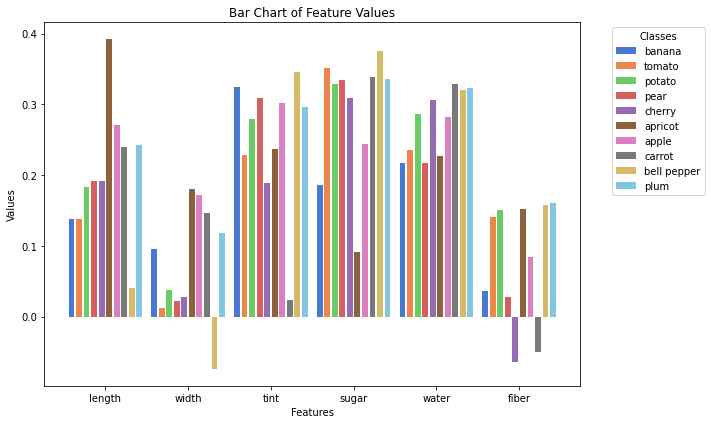

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define the color palette for classes using seaborn
color_palette = sns.color_palette('muted', 10)

# Set up the plotting environment
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as per your requirement

# Get the number of features and classes
num_features = len(df_m.columns)
num_classes = len(df_m)

# Set the bar width and spacing
bar_width = 1 / (num_classes + 1) 
bar_spacing = 0.02

# Generate the x-axis positions for the bars
x = np.arange(num_features)

# Iterate over each class
for i, class_name in enumerate(df_m.index):
    # Get the values for the class
    values = df_m.loc[class_name].values
    
    # Calculate the offset for the bars of the current class
    offset = (i - num_classes / 2 + 0.5) * bar_width
    
    # Plot the bars for each feature
    ax.bar(x + offset, values, width=bar_width - bar_spacing, align='center', color=color_palette[i], label=class_name)

# Customize the plot
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Bar Chart of Feature Values')
ax.set_xticks(x)
ax.set_xticklabels(df_m.columns)

# Move the legend outside of the figure
ax.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the figure layout
fig.tight_layout()

# Show the plot
plt.show()



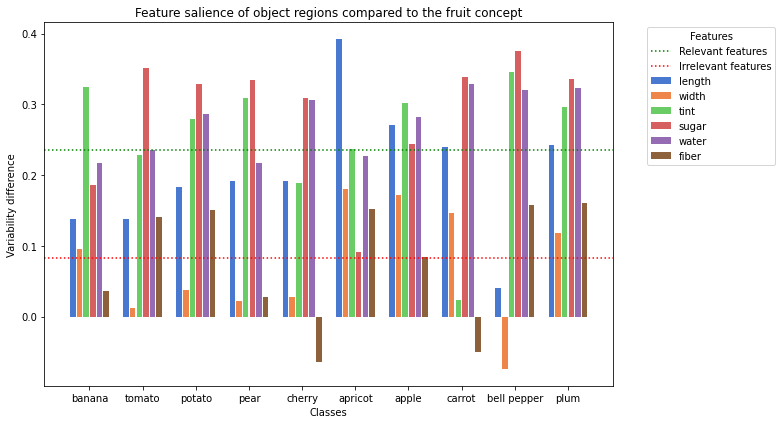

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_m.T

# Define the color palette for classes using seaborn
color_palette = sns.color_palette('muted', 10)

# Set up the plotting environment
fig, ax = plt.subplots(figsize=(11, 6))  # Adjust the figsize as per your requirement

# Get the number of features and classes
num_features = len(df.columns)
num_classes = len(df)

# Set the bar width and spacing
bar_width = 1/ (num_classes + 2) 
bar_spacing = 0.02

# Generate the x-axis positions for the bars
x = np.arange(num_features)

# Iterate over each class
for i, class_name in enumerate(df.index):
    # Get the values for the class
    values = df.loc[class_name].values
    
    # Calculate the offset for the bars of the current class
    # Calculate the offset for the bars of the current class
    offset = (i - num_classes / 2 + 0.5) * bar_width
    
    # Plot the bars for each feature
    ax.bar(x + offset, values, width=bar_width - bar_spacing, align='center', color=color_palette[i], label=class_name)

# Customize the plot
ax.set_xlabel('Classes')
ax.set_ylabel('Variability difference')
ax.set_title('Feature salience of object regions compared to the fruit concept')
ax.set_xticks(x)
ax.set_xticklabels(df.columns)

# Add a red dotted line at 0.1
ax.axhline(y=0.236, color='green', linestyle='dotted', label='Relevant features')
ax.axhline(y=0.083, color='red', linestyle='dotted', label='Irrelevant features')
# Move the legend outside of the figure
ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the figure layout
fig.tight_layout()




# Show the plot
plt.show()